# Boston Insights (TODO: Change the title)
## Data: Boston Airbnb Open Data
The following Airbnb activity is included in this Boston dataset:

- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

Let's start importing the libraries we'll need along the notebook

In [165]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from typing import Any, List, Dict, Tuple
import numpy as np
from udacity_courses.project_1.features.feature_engineer import FeatureEngineer
import statsmodels.api as sm


In [2]:
pd.set_option("display.max_columns", 100)

In [3]:
PROJECT_DIR = Path.cwd().parent
data_path = Path(f"{PROJECT_DIR}/data/airbnb_boston")
listings_df = pd.read_csv(Path(f"{data_path}/listings.csv"))
reviews_df = pd.read_csv(Path(f"{data_path}/reviews.csv"))
calendar_df = pd.read_csv(Path(f"{data_path}/calendar.csv"))

## Exploratory Data Analysis
We'll start doing a little EDA to get some insights from the data we have.

First we'll show the dataframes' first rows to get an idea of how they look like, and we'll get its shape

In [4]:
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

In [5]:
listings_df.shape

(3585, 95)

The Listings dataframe is a quite wide dataframe with 95 columns and 3585 rows, each one corresponding to a different accommodation in the city of Boston.

Let's get an overview of the data types of each column

In [6]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

At a first glampse, we can see a couple of things that are not what one would expect:

*price, weekly_price, monthly_price, cleaning_fee, extra_people* columns are object type. If they contain numerical variables, why are they object type instead of int or float? We'll see it!

In [7]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [8]:
reviews_df.shape

(68275, 6)

In [9]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     68275 non-null  int64 
 1   id             68275 non-null  int64 
 2   date           68275 non-null  object
 3   reviewer_id    68275 non-null  int64 
 4   reviewer_name  68275 non-null  object
 5   comments       68222 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


In [10]:
calendar_df.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [11]:
calendar_df.shape

(1308890, 4)

In [12]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In a simple look at the calendar dataframe info, we see that about the half of the rows have a missing price. Later on we'll see what can these missings mean...
Apart from that, the variable *available* is an object and it could be converted to a boolean.

Comparing all three dataframes, we see that **listings** has quite large amount of columns, so we'll be able to extract more insights from there (and also more work) than in the other 2 dataframes.

Let's see why some columns that we would expect to have numeric values, are object type:

In [13]:
listing_variables_to_check_type = ["price", "weekly_price", "monthly_price", "cleaning_fee", "extra_people"]
listings_df[listing_variables_to_check_type].head()

,price,weekly_price,monthly_price,cleaning_fee,extra_people
0,$250.00,NaN,NaN,$35.00,$0.00
1,$65.00,$400.00,NaN,$10.00,$0.00
2,$65.00,$395.00,"$1,350.00",NaN,$20.00
3,$75.00,NaN,NaN,$50.00,$25.00
4,$79.00,NaN,NaN,$15.00,$0.00


We see that they are objects because they contain the dollar ($) symbol on it. Let's remove it and convert it into float type

In [14]:
# We need to create a function because the straight forward replacement can't be done because some values don't have the dollar symbol
def convert_to_float(value):
    """
    Function to handle both $ symbol, thousands separator, and decimal separator
    Args:
        value: argument that contains the value to treat

    Returns:
        The value converted to a float or None
    """
    # Check if the value is a string
    if isinstance(value, str):
        # Remove the $ symbol
        value = value.replace('$', '')

        # Handle commas as thousands separator
        value = re.sub(r'(?<=\d),(?=\d{3}(\D|$))', '', value)

        # Replace commas as decimal separator with a dot
        value = value.replace(',', '.')

        # Replace %
        value = value.replace("%", "")

        # Convert to float (if not empty)
        return float(value) if value else None

    # If the value is already a float, return it as is
    elif isinstance(value, float):
        return value

    # For other types (e.g., None), return None
    else:
        return None

In [15]:
for var in listing_variables_to_check_type:
    listings_df[var] = listings_df[var].apply(convert_to_float)
listings_df[listing_variables_to_check_type].dtypes

price            float64
weekly_price     float64
monthly_price    float64
cleaning_fee     float64
extra_people     float64
dtype: object

We see that these variables have been converted to float correctly!

While checking the calendar dataframe above, we saw that *available* is an object variable. It contains *t* to represent *True* and *f* to represent *False*. We'll map it to a boolean variable:

In [16]:
calendar_df["available"] = calendar_df["available"].map({"f": False, "t": True})
calendar_df["available"] = calendar_df["available"].astype(bool)
calendar_df["price"] = calendar_df["price"].apply(convert_to_float)
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   listing_id  1308890 non-null  int64  
 1   date        1308890 non-null  object 
 2   available   1308890 non-null  bool   
 3   price       643037 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 31.2+ MB


With this simple modifications, we reduced the size of the dataframe on 8 MB

### What are the most popular neighbourhoods in Boston for the AirBnB users?

We'll use the column *neighbourhood_cleansed*, which contains the neighbourhood after applying some cleansing methods (such as filling the missing values) on the *neighbourhood* variable.


First of all we'll see the neighbourhoods where there are more listings:

In [17]:
def create_countplot(series: pd.Series, title: str, x_label: str, y_label: str):
    series = series.copy()
    counts = series.value_counts()
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45, ha='right')
    plt.show()

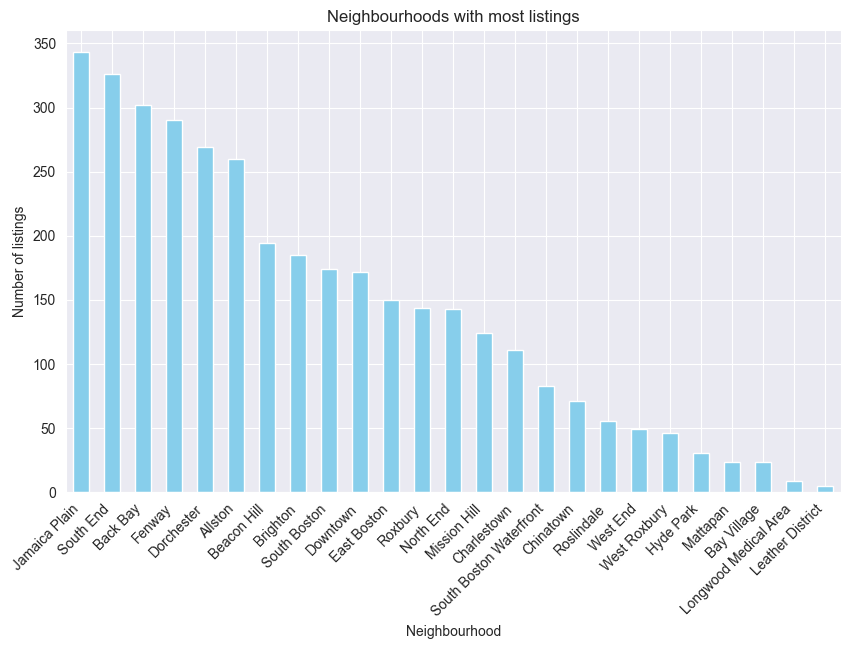

In [18]:
create_countplot(listings_df["neighbourhood_cleansed"], "Neighbourhoods with most listings", "Neighbourhood", "Number of listings")

We see that the top 5 neighbourhoods with more listings are *Jamaica Plain, South End, Back Bay, Fenway and Dorchester*. Let's see if this chart matches with the most demanded neighbourhoods. For that, we'll use the calendar dataframe:

In [19]:
calendar_df_neighb = calendar_df.merge(listings_df[["id", "neighbourhood_cleansed"]], left_on="listing_id", right_on="id").drop(columns=["id"])
calendar_df_neighb.head()

,listing_id,date,available,price,neighbourhood_cleansed
0,12147973,2017-09-05,False,NaN,Roslindale
1,12147973,2017-09-04,False,NaN,Roslindale
2,12147973,2017-09-03,False,NaN,Roslindale
3,12147973,2017-09-02,False,NaN,Roslindale
4,12147973,2017-09-01,False,NaN,Roslindale


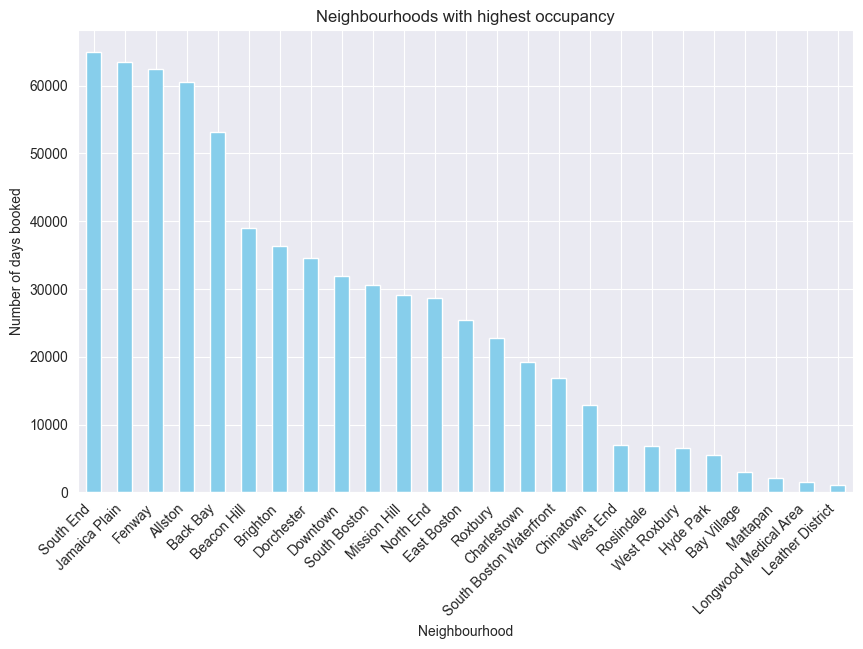

In [20]:
create_countplot(calendar_df_neighb[calendar_df_neighb["available"] == False]["neighbourhood_cleansed"],
                 "Neighbourhoods with highest occupancy", "Neighbourhood", "Number of days booked")

We see that the neighbourhoods are ordered differently. Let's compare both charts in a single one. Since we have different units, we'll use the percentual popularity.

In [21]:
def create_superposed_countplots(series1: pd.Series, series2: pd.Series, title: str, x_label: str, y_label: str, label1: str, label2: str):
    # Calculate percentual frequency for each series
    percentages1 = series1.value_counts(normalize=True)
    percentages2 = series2.value_counts(normalize=True)

    # Plot the superposed bar charts with transparency
    plt.figure(figsize=(10, 6))
    plt.bar(percentages1.index, percentages1, color="skyblue", alpha=0.5, label=label1)
    plt.bar(percentages2.index, percentages2, color="orange", alpha=0.5, label=label2)

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

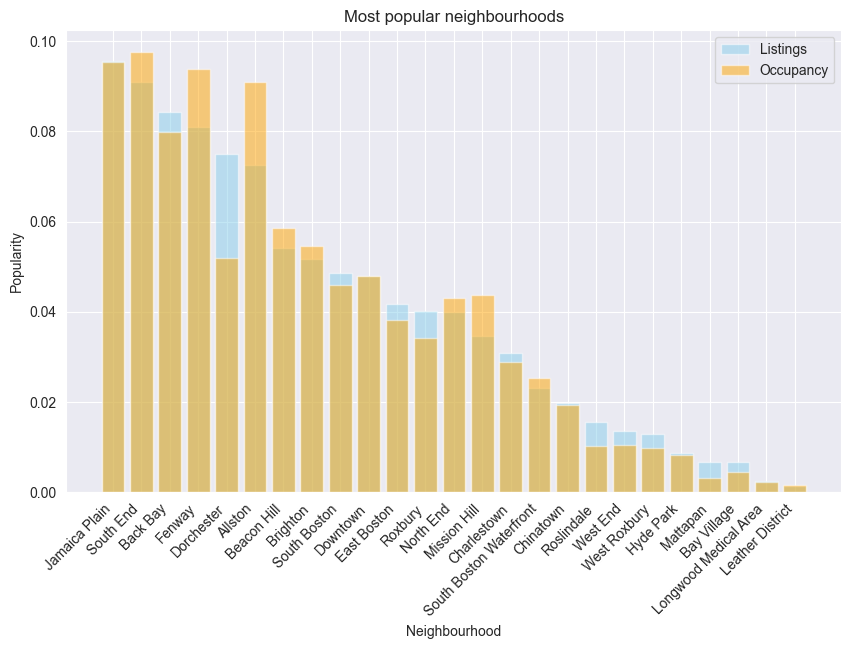

In [22]:
series1 = listings_df["neighbourhood_cleansed"]
series2 = calendar_df_neighb[calendar_df_neighb["available"] == False]["neighbourhood_cleansed"]
create_superposed_countplots(series1, series2, "Most popular neighbourhoods", "Neighbourhood", "Popularity", "Listings", "Occupancy")

Here we can see that *Jamaica Plain* neighbourhood popularity in the listing dataframe matches with the popularity on the reservations. *South End, Fenway* and *Allston*, are relatively more popular in terms of reservations than offer, while, on the other hand, *Back Bay* and *Dorchester* have more offer than demand, relatively.

### What are the most expensive neighbourhoods to spend some nights in Boston?

We'll not show the average price per neighbourhood, but we'll also consider the average price per number of guests

In [23]:
def create_barplot(series: pd.Series, title: str = "", x_label: str = "", y_label: str = ""):
    """
    Generate a bar plot using Seaborn for a pandas Series.

    Parameters:
    - series (pd.Series): Pandas Series containing the data.
    - title (str): Title of the plot.
    - x_label (str): Label for the x-axis.
    - y_label (str): Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    series.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [24]:
def create_superposed_barplots(series1: pd.Series, series2: pd.Series, title: str="", x_label: str="", y_label: str="", label1: str="", label2: str=""):
    # Plot the superposed bar charts with transparency
    plt.figure(figsize=(10, 6))
    plt.bar(series1.index, series1, color="skyblue", alpha=0.5, label=label1)
    plt.bar(series2.index, series2, color="orange", alpha=0.5, label=label2)

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [25]:
listings_df_avg_price = listings_df[["price", "weekly_price", "monthly_price", "neighbourhood_cleansed", "accommodates"]].copy()
listings_df_avg_price["price_per_accommodate"] = listings_df_avg_price["price"] / listings_df_avg_price["accommodates"]
avg_price_neigh = listings_df_avg_price.groupby(by="neighbourhood_cleansed")["price"].mean().sort_values(ascending=False)
avg_price_acomm_neigh = listings_df_avg_price.groupby(by="neighbourhood_cleansed")["price_per_accommodate"].mean().sort_values(ascending=False)
avg_price_neigh_ = pd.merge(avg_price_neigh, avg_price_acomm_neigh, how="left", on="neighbourhood_cleansed")

In [26]:
avg_price_neigh_.reset_index()

,neighbourhood_cleansed,price,price_per_accommodate
0,South Boston Waterfront,306.060241,90.064257
1,Bay Village,266.833333,74.270833
2,Leather District,253.600000,92.550000
3,Back Bay,240.950331,80.405263
4,Downtown,236.459302,76.290628
5,Chinatown,232.352113,67.488732
6,Beacon Hill,224.443299,86.689801
7,Fenway,220.393103,83.435587
8,West End,209.591837,61.656803
9,South End,204.349693,78.206643


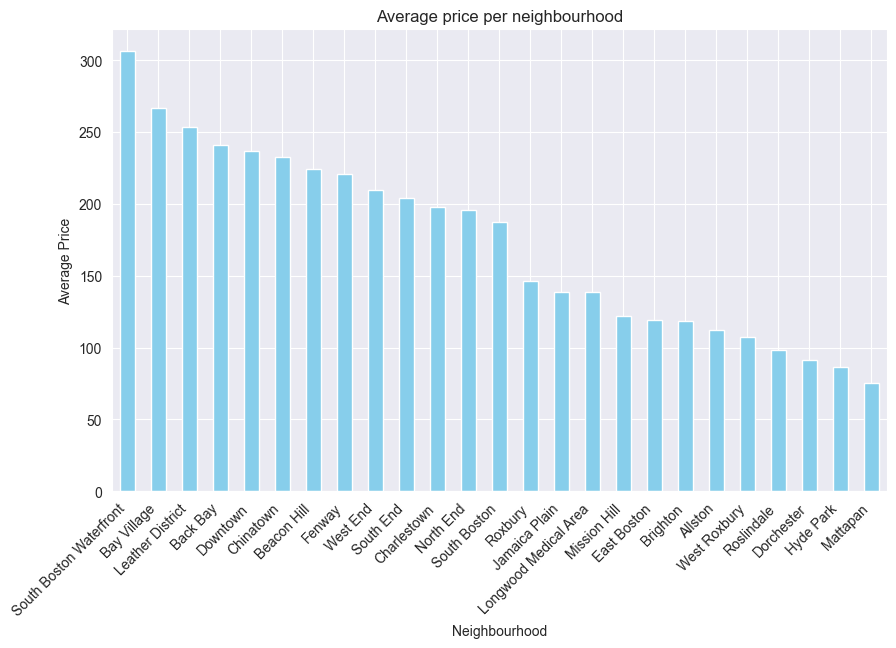

In [27]:
create_barplot(avg_price_neigh, "Average price per neighbourhood", "Neighbourhood", "Average Price")

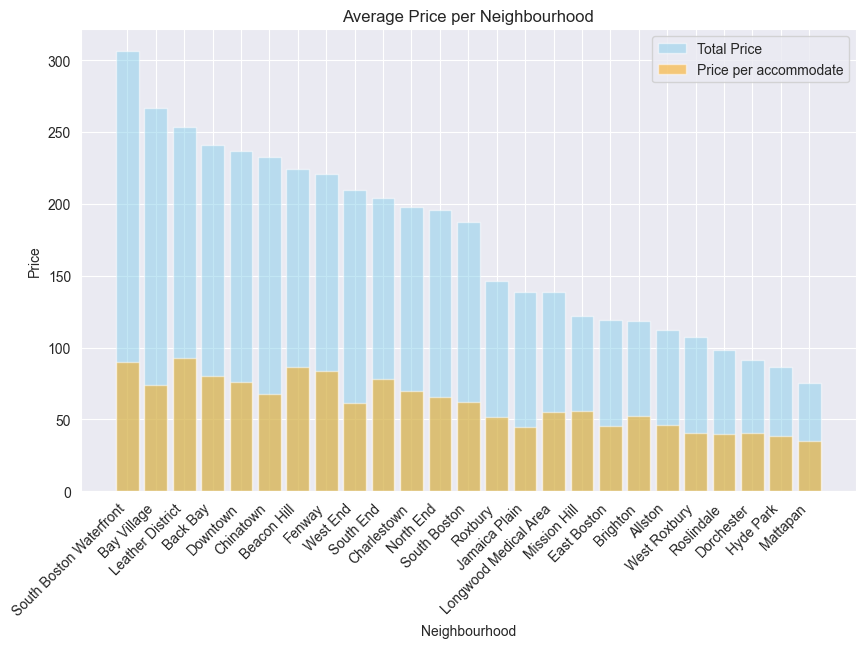

In [28]:
create_superposed_barplots(avg_price_neigh, avg_price_acomm_neigh, "Average Price per Neighbourhood", "Neighbourhood", "Price", "Total Price", "Price per accommodate")

We see that the Total Price per Accommodation has a different distribution than the Price per Accommodate. From here, we could think that even though the most expensive accommodations are in *South Boston Waterfront*, if you travel accompanied, there are more chances to find cheaper options than in *Leather District* (if expenses are split).

*Bay Village*, for example, is the second most expensive Neighbourhood if we consider the price of the full accommodation, but if we take into account the number of people that can fit in the accommodation, it drops 6 positions. This could indicate that Bay Village tends to have bigger apartments or houses.

### What are the most popular property types in Boston?

When we travel, some people can find more suitable to stay in a house or apartment, while others prefer stay in a Bed and Breakfast, for instance.. Besides choosing that, we can also choose whether to stay in a private room, shared room or to rent an entire home. What is your preference? Do you always find your favourite option?

Let's see how is the market in Boston

In [29]:
print(listings_df["room_type"].unique())

['Entire home/apt' 'Private room' 'Shared room']


We see that each accommodation listed in the dataset can refer to an entire home, private or shared room.

In [30]:
print(listings_df["property_type"].unique())

['House' 'Apartment' 'Condominium' 'Villa' 'Bed & Breakfast' 'Townhouse'
 'Entire Floor' 'Loft' 'Guesthouse' 'Boat' 'Dorm' 'Other' nan 'Camper/RV']


In terms of the property type, we have many options. Let's see it graphically:

In [31]:
def create_piechart(series: pd.Series, title: str = "", threshold: float = 0.02):
    """
    Generate a pie chart using Matplotlib for a pandas Series, grouping percentages below a threshold into 'Others'.

    Parameters:
    - series (pd.Series): Pandas Series containing the data.
    - title (str): Title of the plot.
    - threshold (float): Percentage threshold below which values are grouped into 'Others'.
    """
    # Calculate percentages
    percentages = series / series.sum()

    # Group values below the threshold into 'Others'
    mask = percentages >= threshold
    series_to_plot = series[mask]
    series_to_plot['Others'] = series[~mask].sum()

    # Get the number of categories (excluding 'Others')
    num_categories = len(series_to_plot)

    # Get a colormap with as many colors as categories
    colors = plt.colormaps.get_cmap('tab10')

    # Plot the pie chart
    plt.figure(figsize=(8, 8))
    pie_chart = series_to_plot.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors.colors,  pctdistance=0.7)

    # Set legend outside the pie chart
    plt.legend(series_to_plot.index, bbox_to_anchor=(1, 0.5), loc="center left", title="Categories")
    plt.title(title)
    plt.ylabel("")  # No need for y-axis label in a pie chart
    plt.show()

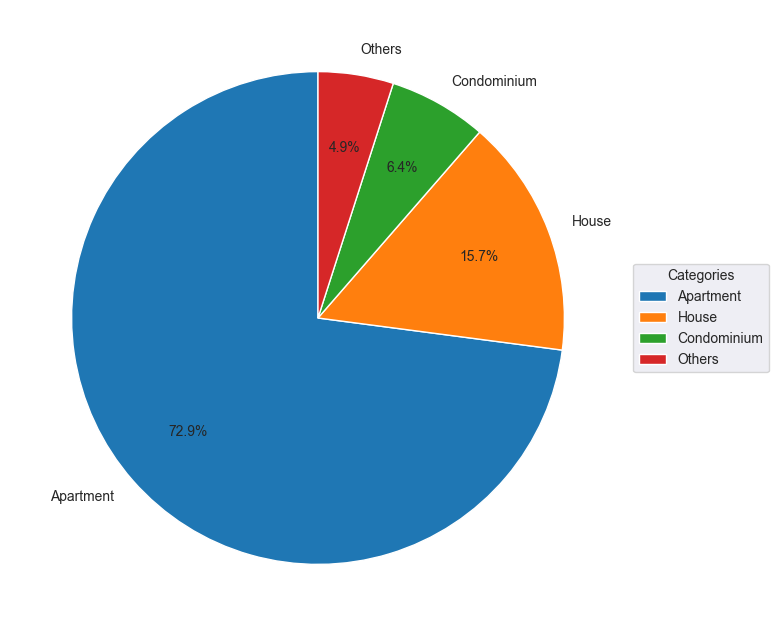

In [32]:
create_piechart(listings_df["property_type"].value_counts())

We see that almost 3 out of 4 accommodations listed in Boston's Airbnb are appartments. Then we can find houses, condominium. Other property types represent less than the 5% of the properties. We can see more detailed results in the following table:

In [33]:
listings_df["property_type"].value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64

### What is the price distribution of the listings dataset?
Here we'll study how the variable price is distributed in the listings dataset. By doing this we can gain valuable insights into the pricing strategies or patterns that Boston Airbnb listings follow.
We'll start with some basic descriptive statistics:

In [145]:
listings_df["price"].describe()

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

From this descriptive statistics above, we can see that the mean is higher than the median, what means that we'll have a right skewed distribution. It can be because we have a relatively few extreme high values that contribute to pulling the mean to the right, so there are a few accommodations with extremely high prices. In fact, if we look at the minimum and maximum values, we see that the minimum is just 140&#36; far away from the median, while the maximum is 3850&#36; far away from the median. We'll see better in a histogram.

We can also see that the variable price has a quite high range and dispersion. The standard deviation is 148&#36, which means that on average the prices in the dataset tend to deviate 148$. It can be explained by the differences of the nature of the accommodations (from room in a shared apartment in the suburbs to a fancy entire apartment in a fancy building with nice views)

We could apply a logarithmic transformation to try to normalize these data.

In [162]:
def create_histogram(series: pd.Series, title: str = "", bins: int = 10, xlim=None, log_scale=False):
    """
    Generate a histogram using Seaborn for a pandas Series.

    Parameters:
    - series (pd.Series): Pandas Series containing the data.
    - title (str): Title of the plot.
    - bins (int): Number of bins for the histogram.
    - xlim (tuple): Tuple containing the lower and upper limits for the x-axis.
    - log_scale (bool): Whether to use a logarithmic scale for the data.
    """
    series = series.copy()

    plt.figure(figsize=(10, 6))

    # Apply log scale if specified
    if log_scale:
        series = np.log(series)

    # Calculate bin edges based on xlim
    if xlim:
        bin_edges = np.linspace(xlim[0], xlim[1], bins + 1)
    else:
        bin_edges = bins

    sns.histplot(series, bins=bin_edges, color='skyblue', kde=False)
    plt.title(title)

    # Set x-axis limits manually if provided
    if xlim:
        plt.xlim(xlim)

    plt.show()

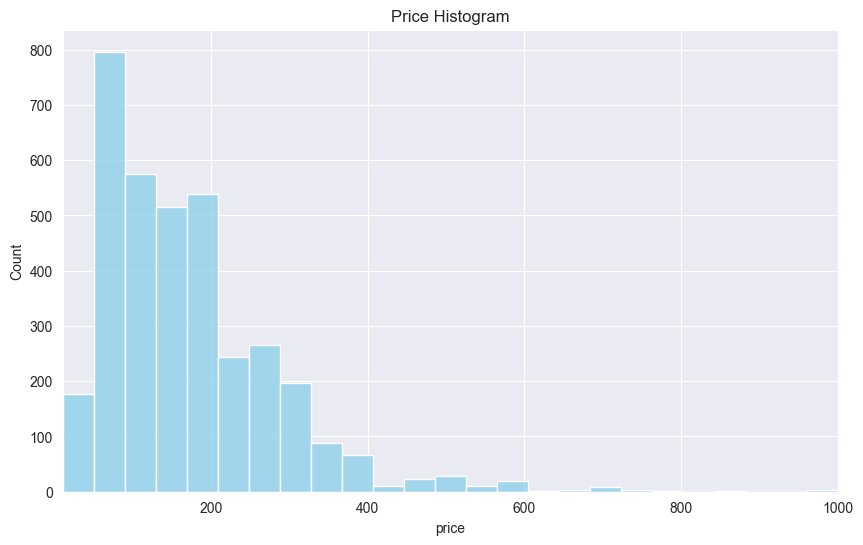

In [159]:
create_histogram(listings_df["price"], "Price Histogram", bins=25, xlim=[10,1000])

We cut this histogram to make it more interpretable. We have a visualization of what we commented before: the distribution has a long right tail. Since the distribution is not normal we could think that prediction models that assume that the variables follow a normal distribution, could fail.

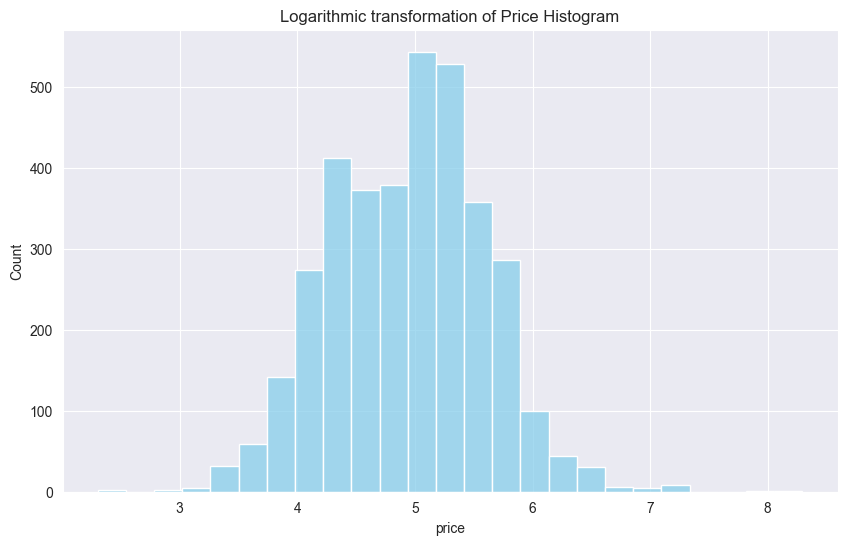

In [164]:
create_histogram(listings_df["price"], "Logarithmic transformation of Price Histogram", bins=25, log_scale=True)

After a logarithmic transformation, the distribution of the variable look much normal. Let's visualize a QQ plot

In [167]:
def create_qqplot(series: pd.Series):
    """
    Generate a QQ plot using statsmodels and Seaborn for a pandas Series.

    Parameters:
    - series (pd.Series): Pandas Series containing the data.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))

    # Create QQ plot using statsmodels
    sm.qqplot(series, line='q', color='skyblue')

    plt.show()

/Users/heribertroig/opt/anaconda3/envs/udacity-courses/lib/python3.10/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 1000x600 with 0 Axes>

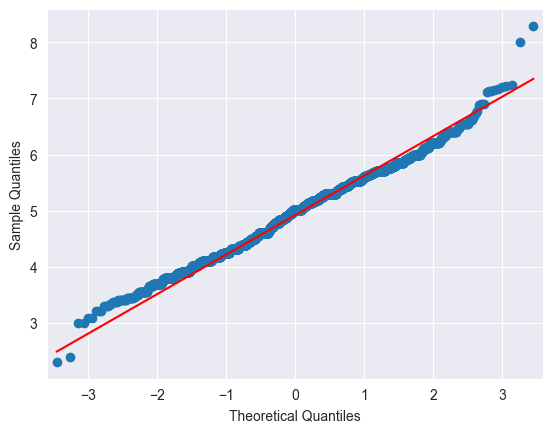

In [168]:
create_qqplot(np.log(listings_df["price"]))

We could assume that the logarithmic transformation of the price follow a normal distribution

### Is there any seasonal trend on prices and occupancy?

Another business question is to know whether there is a seasonal component in the price and occupancy in the Boston accommodations. Let's see it!

If we go back to the calendar dataframe first rows seen, we can see that in the column **price** there are many missing values. Let's check how many missing values are in the calendar dataframe:

In [34]:
calendar_df.isnull().sum()

listing_id         0
date               0
available          0
price         665853
dtype: int64

There are many missing values. Are they meaningful? Let's check if there is any relationship with the availability

In [35]:
print(f'Whenever the price column is missing, the availability column has these values: {calendar_df[calendar_df["price"].isna()]["available"].unique()}')
print(f'Whenever the price column is not missing, the availability column has these values: {calendar_df[calendar_df["price"].notna()]["available"].unique()}')

Whenever the price column is missing, the availability column has these values: [False]
Whenever the price column is not missing, the availability column has these values: [ True]


Indeed, we see that whenever the price is missing, the availability is False, and vice versa! So we are able to know whenever a listing is available or not

Let's visualize the price trend along the year

First we'll transform the date column into a date, and to clean the price column

In [36]:
calendar_df["date"] = pd.to_datetime(calendar_df["date"], format="%Y-%m-%d")
calendar_df.head()

,listing_id,date,available,price
0,12147973,2017-09-05,False,NaN
1,12147973,2017-09-04,False,NaN
2,12147973,2017-09-03,False,NaN
3,12147973,2017-09-02,False,NaN
4,12147973,2017-09-01,False,NaN


Now we'll use a monthly boxplot to see if there's any seasonality

In [37]:
def create_seasonal_boxplot(data: pd.DataFrame, time_column: str, value_column: str):
    """
    Create a seasonal boxplot for a given DataFrame.

    Parameters:
    - data: DataFrame containing the data.
    - time_column: Name of the datetime column in the DataFrame.
    - value_column: Name of the numerical column for which to create the boxplot.
    """
    data = data.copy()
    # Extract month from the datetime column
    data['Month'] = data[time_column].dt.month

    # Calculate the highest mean + 2 times standard deviation
    # upper_limit = data.groupby('Month')[value_column].mean().max() + 2 * data.groupby('Month')[value_column].std().max()
    upper_limit = 400

    # Create a boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Month', y=value_column, data=data)
    plt.title(f'Seasonal Boxplot for {value_column}')
    plt.xlabel('Month')
    plt.ylabel(value_column)
    plt.ylim(0, upper_limit)  # Set y-axis limits

    plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    plt.show()

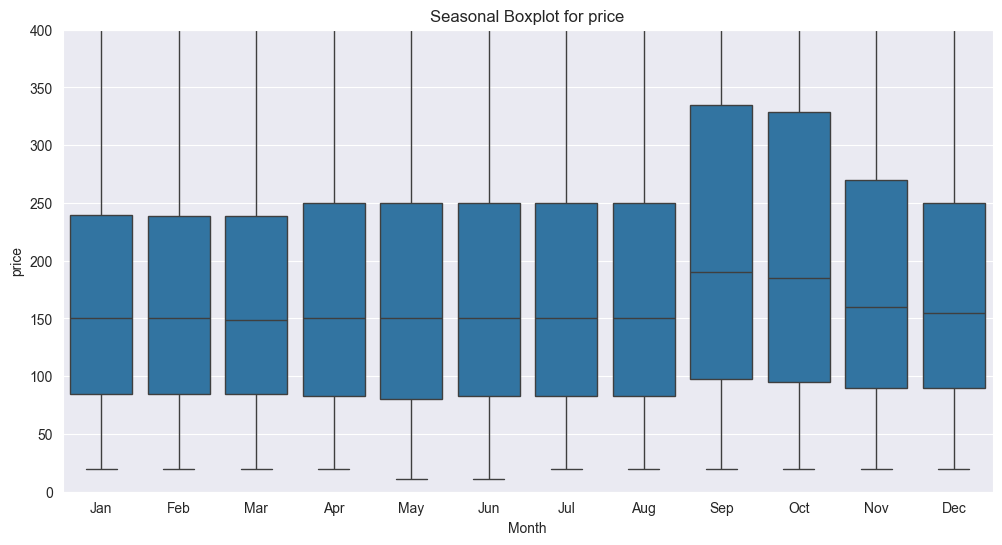

In [38]:
create_seasonal_boxplot(calendar_df, "date", "price")

Analyzing this boxplot, it seems that in september and october there's an increase of the price, even though we don't see any significant difference.

However, let's dig a bit to see if we can find any relationship with the occupancy. We'd expect that when the price is higher, it is because the demand is higher, too.

In [39]:
def create_monthly_line_plot(data, time_column, value_column):
    """
    Create a line plot for a given DataFrame with monthly data.

    Parameters:
    - data: DataFrame containing the data.
    - time_column: Name of the datetime column in the DataFrame.
    - value_column: Name of the numerical column for which to create the line plot.
    """
    data = data.copy()
    # Extract month from the datetime column
    data['Month'] = data[time_column].dt.month

    # Calculate the mean value for each month
    monthly_means = data.groupby('Month')[value_column].mean()

    # Create a line plot
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_means.index, monthly_means.values, marker='o', linestyle='-')
    plt.title(f'Monthly Line Plot for {value_column}')
    plt.xlabel('Month')
    plt.ylabel(value_column)

    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    plt.show()

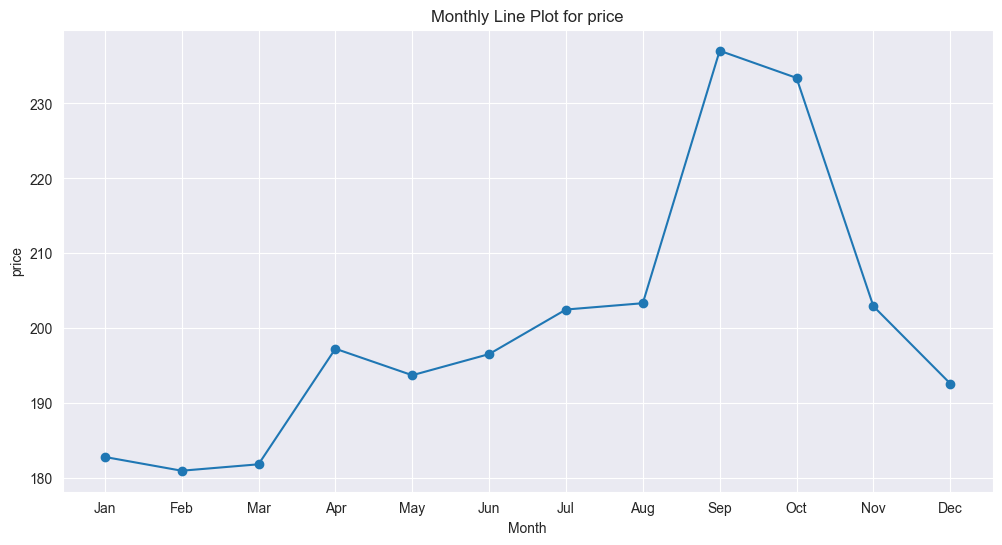

In [40]:
create_monthly_line_plot(calendar_df, "date", "price")

Having the previous boxplot in mind, we wouldn't expect to have this seasonal behaviour looking at the mean price. Boxplots are robust to outliers because they are based on percentiles, but this line chart uses the mean, which is not robust to them. So we could face that on September and October there are some outliers. Let's find them!

In [41]:
import pandas as pd

def find_outliers(data, time_column, value_column, months=[]):
    """
    Find outliers in a specified column of a DataFrame for each unique listing_id.
    Additionally, calculate the median price for each listing_id. The threshold to
    consider an observation, an outlier is to have a value +- 50% of the median.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the data.
    - time_column (str): The name of the column containing date/time information.
    - value_column (str): The column to look for outliers.
    - month (int, optional): The month to filter outliers. If None, all months are considered.

    Returns:
    - outliers_with_median (pd.DataFrame): DataFrame containing the outliers and median price,
                                           including the 'month' column.
    """
    data = data.copy()
    data.dropna(subset=["price"], inplace=True)
    # Extract month from the datetime column
    data['month'] = data[time_column].dt.month

    # Filter data by the specified month, if provided
    if months:
        data = data[data[time_column].dt.month.isin(months)]

    # Define a function to find outliers for each group and calculate median price
    def find_outliers_group(group):
        Q1 = group[value_column].quantile(0.25)
        Q3 = group[value_column].quantile(0.75)
        Q2 = group[value_column].quantile(0.50)
        IQR = Q3 - Q1
        threshold = IQR
        # threshold = Q2 * 0.5

        lower_bound = Q1 - 1.5 * threshold
        upper_bound = Q3 + 1.5 * threshold
        outliers = group[(group[value_column] < lower_bound) | (group[value_column] > upper_bound)]
        median_price = group[value_column].median()
        outliers['median_price'] = median_price
        return outliers

    # Apply the function to each group defined by "listing_id"
    outliers_with_median = data.groupby('listing_id').apply(find_outliers_group).reset_index(drop=True)
    outliers_with_median["absolute_diff"] = (outliers_with_median['price'] - outliers_with_median['median_price'])
    outliers_with_median["percentage_diff"] = (outliers_with_median['price'] - outliers_with_median['median_price']) / outliers_with_median['median_price']

    return outliers_with_median


In [42]:
outliers = find_outliers(calendar_df, "date", "price")#.reset_index().sort_values(by=["listing_id", "price"], ascending=False)
print(outliers.shape)
outliers.head(20)

(25710, 8)


,listing_id,date,available,price,month,median_price,absolute_diff,percentage_diff
0,3353,2017-02-18,True,33.0,2,36.0,-3.0,-0.083333
1,3353,2017-02-14,True,33.0,2,36.0,-3.0,-0.083333
2,3353,2017-02-13,True,33.0,2,36.0,-3.0,-0.083333
3,3353,2017-02-12,True,33.0,2,36.0,-3.0,-0.083333
4,3353,2017-02-11,True,33.0,2,36.0,-3.0,-0.083333
5,3353,2017-02-09,True,33.0,2,36.0,-3.0,-0.083333
6,3353,2017-02-08,True,33.0,2,36.0,-3.0,-0.083333
7,3353,2017-02-07,True,33.0,2,36.0,-3.0,-0.083333
8,3353,2017-02-06,True,33.0,2,36.0,-3.0,-0.083333
9,3353,2017-02-05,True,33.0,2,36.0,-3.0,-0.083333


We see that many outliers have been found in the whole dataset. Let's groupby the listing and month and get the mean.

In [43]:
outliers_grouped = outliers.groupby(["listing_id", "month", "median_price"])["price", "percentage_diff", "absolute_diff"].mean()
print(outliers_grouped.shape)
outliers_grouped

(2735, 3)


/var/folders/z0/1x89lkgx1n102bf_zx1z6t980000gn/T/ipykernel_53803/835503750.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  outliers_grouped = outliers.groupby(["listing_id", "month", "median_price"])["price", "percentage_diff", "absolute_diff"].mean()


price  percentage_diff  absolute_diff
listing_id month median_price                                            
3353       1     36.0           32.612903        -0.094086      -3.387097
           2     36.0           33.000000        -0.083333      -3.000000
           12    36.0           32.000000        -0.111111      -4.000000
5506       4     145.0         275.000000         0.896552     130.000000
6695       4     195.0         325.000000         0.666667     130.000000
...                                   ...              ...            ...
14916248   10    125.0         136.285714         0.090286      11.285714
           11    125.0         134.333333         0.074667       9.333333
           12    125.0         133.391304         0.067130       8.391304
14924831   12    173.0         132.000000        -0.236994     -41.000000
14933461   9     165.0         182.000000         0.103030      17.000000

[2735 rows x 3 columns]

In [44]:
outliers_grouped.sort_values(by="percentage_diff", ascending=False)

price  percentage_diff  absolute_diff
listing_id month median_price                                             
447826     10    71.0          7163.000000        99.887324    7092.000000
11866651   4     434.0         3000.000000         5.912442    2566.000000
14215317   4     245.0         1500.000000         5.122449    1255.000000
11983286   9     51.0           306.666667         5.013072     255.666667
6838488    4     550.0         2895.000000         4.263636    2345.000000
...                                    ...              ...            ...
14683493   7     149.0           20.000000        -0.865772    -129.000000
           8     149.0           20.000000        -0.865772    -129.000000
           9     149.0           20.000000        -0.865772    -129.000000
9974833    11    249.0           29.000000        -0.883534    -220.000000
           12    249.0           29.000000        -0.883534    -220.000000

[2735 rows x 3 columns]

We see that in october there's an outlier, which seems to be a data issue, since the price is 100 times the original price, so we'll just remove this observation from the data (we could also keep the observation and suppose that in the apartment there was a party and some furniture were destroyed and the guests had to pay for it, but we consider a safer option to just remove this data point). Other outliers seem to be acceptable, so some accommodation prices raise at some points, but the maximum price increase is 6x the original price.

In [45]:
calendar_df[(calendar_df["listing_id"] == 447826) & (calendar_df["price"] == 7163.0)]

,listing_id,date,available,price
110179,447826,2016-10-26,True,7163.0


In [46]:
index_to_remove = calendar_df[(calendar_df["listing_id"] == 447826) & (calendar_df["price"] == 7163.0)].index
calendar_df = calendar_df.drop(index_to_remove)

Now let's see if we can find any relationship between the average occupancy and price trends

In [47]:
def superpose_line_plots_dual_axes(data, time_column, value_column1, value_column2):
    """
    Create a line plot with two superposed lines and dual y-axes for given DataFrame and columns.

    Parameters:
    - data: DataFrame containing the data.
    - time_column: Name of the datetime column in the DataFrame.
    - value_column1: Name of the first numerical column for the line plot.
    - value_column2: Name of the second numerical column for the line plot.
    """
    # Extract month from the datetime column
    data['Month'] = data[time_column].dt.month

    # Calculate the mean value for each month for both columns
    monthly_means1 = data.groupby('Month')[value_column1].mean()
    monthly_means2 = data.groupby('Month')[value_column2].mean()

    # Calculate the mean value and standard deviation for each column
    mean1, std1 = data[value_column1].mean(), data[value_column1].std()
    mean2, std2 = data[value_column2].mean(), data[value_column2].std()

    # Calculate y-axis limits
    std_multiplier = 0.5
    lower_limit1, upper_limit1 = mean1 - std_multiplier * std1, mean1 + std_multiplier * std1
    lower_limit2, upper_limit2 = mean2 - std_multiplier * std2, mean2 + std_multiplier * std2

    # Create a line plot with the first y-axis
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(monthly_means1.index, monthly_means1.values, marker='o', linestyle='-', label=value_column1, color='skyblue')
    ax1.set_xlabel('Month')
    ax1.set_ylabel(value_column1, color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_ylim(lower_limit1, upper_limit1)

    # Create a second y-axis for the second line plot
    ax2 = ax1.twinx()
    ax2.plot(monthly_means2.index, monthly_means2.values, marker='o', linestyle='-', label=value_column2, color='orange')
    ax2.set_ylabel(value_column2, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(0.25, 0.75)

    # Optional: Set x-axis ticks to represent months (1 to 12)
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    # Add legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.title(f'Monthly Line Plot for {value_column1} and {value_column2}')
    plt.show()

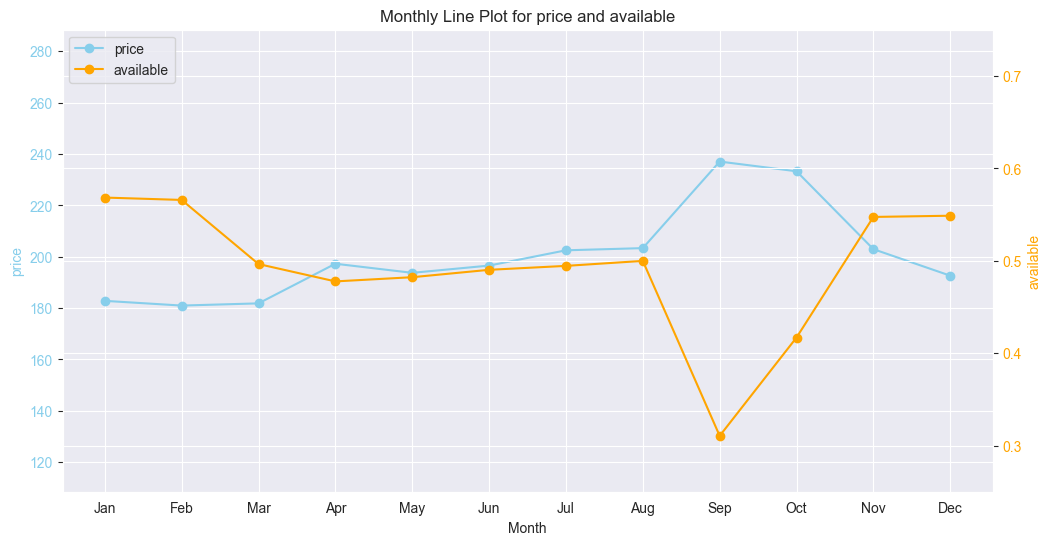

In [48]:
superpose_line_plots_dual_axes(calendar_df, "date", "price", "available")

We clearly see that price and availability are inversely related, so when one factor increases, the other one decreases. For instance, we see that in winter season, the availability is higher and prices are quite lower, while in september and october availability drops, and price rises. This peak of the price and drop of the availability in the fall season can be a cause of the start of the academic year, where more students go to the city and book an airbnb until they find their final accommodation. Also, because the weather seem to be pleasant, while in winter, temperatures drop below zero it might not be as appealing to tourism.

Another interesting thing is that from April until August, it seems that the price - availability relationship is balanced and stable.

### What are the most influential features on the price and occupancy of a listing?
Now we'll develop some methods to try to figure out what are the most important factors that determine a price of accommodation in Boston.

We'll start with some feature engineer

In [49]:
listings_df_fe = listings_df.copy()

Let's see what are the categorical columns we have in the dataset

In [50]:
categorical_columns = listings_df_fe.select_dtypes(include=['category', 'object']).columns.tolist()
print(categorical_columns)

['listing_url', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'property_type', 'room_type', 'bed_type', 'amenities', 'security_deposit', 'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review', 'requires_license', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification']


In [51]:
listings_df_fe[categorical_columns].head()

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,security_deposit,calendar_updated,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,https://www.airbnb.com/rooms/12147973,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,MA,02131,Boston,"Boston, MA",US,United States,t,House,Entire home/apt,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,2 weeks ago,2016-09-06,NaN,NaN,f,f,moderate,f,f
1,https://www.airbnb.com/rooms/3075044,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,MA,02131,Boston,"Boston, MA",US,United States,t,Apartment,Private room,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$95.00,a week ago,2016-09-06,2014-06-01,2016-08-13,f,t,moderate,f,f
2,https://www.airbnb.com/rooms/6976,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,"PUBLIC TRANSPORTATION: From the house, quick p...","I am living in the apartment during your stay,...","ABOUT ME: I'm a laid-back, friendly, unmarried...","I encourage you to use my kitchen, cooking and...",https://a2.muscache.com/im/pict

There are many variables that contain text. Analyzing these text columns is out of the scope of this notebook, so we'll just get rid of them

In [52]:
text_vars = ["listing_url", "last_scraped", "name", "summary", "space", "description", "neighborhood_overview", "notes", "transit", "access", "interaction", "house_rules", "thumbnail_url", "medium_url", "picture_url", "xl_picture_url", "host_url", "host_name", "host_location", "host_about", "host_thumbnail_url", "host_picture_url", "street", "amenities"]

In [53]:
def constant_columns(df: pd.DataFrame):
    constant_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            constant_cols.append(col)
        continue
    return constant_cols

In [54]:
constant_cols = constant_columns(listings_df_fe)
print(constant_cols)

['scrape_id', 'last_scraped', 'experiences_offered', 'neighbourhood_group_cleansed', 'state', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names']


Finally, there are some variables that we consider that won't add any value in the analysis, maybe because they are just ids, or they have equivalent columns

In [112]:
vars_to_exclude = ["id", "scrape_id", "host_id", "license", "jurisdiction_names", "neighbourhood", "host_verifications", "smart_location", "city", "host_total_listings_count", "zipcode", "latitude", "longitude"]

In [113]:
cols_to_remove = text_vars + constant_cols + vars_to_exclude + ["weekly_price", "monthly_price"] # We consider that weekly price and monthly price should not be used to explain the variable price, since it could be considered a data leakage.
cols_to_change_type = ["cleaning_fee",
                       "security_deposit", "host_response_rate", "host_acceptance_rate"]
date_columns = ["host_since", "first_review", "last_review"]
boolean_columns = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified",
                   "is_location_exact", "instant_bookable", "require_guest_profile_picture", "require_guest_phone_verification"]
categorical_cols = [col for col in categorical_columns if col not in (cols_to_remove + cols_to_change_type + date_columns + boolean_columns)]

Now we'll apply some feature engineer on the variables. It will include: transform object variables to float, and transform object variables to boolean:

In [114]:
def _change_dtype(df: pd.DataFrame, cols_to_change_type) -> pd.DataFrame:
    df = df.copy()
    for col in cols_to_change_type:
        df[col] = df[col].apply(convert_to_float)
    return df
listings_df_fe = _change_dtype(listings_df_fe, cols_to_change_type)

In [115]:
def _transform_bool_columns(df: pd.DataFrame, boolean_columns) -> pd.DataFrame:
    df = df.copy()
    for col in boolean_columns:
        df[col] = df[col].map({"f": False, "t": True})
        df[col] = df[col].astype(bool)
    return df
listings_df_fe = _transform_bool_columns(listings_df_fe, boolean_columns)

Now we'll investigate a little the *missing values*: what they represent and how we are going to manage them.

In [116]:
listings_df_fe.drop(columns=cols_to_remove).isna().sum()

host_since                             0
host_response_time                   471
host_response_rate                   471
host_acceptance_rate                 471
host_is_superhost                      0
host_neighbourhood                   339
host_listings_count                    0
host_has_profile_pic                   0
host_identity_verified                 0
neighbourhood_cleansed                 0
market                                14
is_location_exact                      0
property_type                          3
room_type                              0
accommodates                           0
bathrooms                             14
bedrooms                              10
beds                                   9
bed_type                               0
square_feet                         3529
price                                  0
security_deposit                    2243
cleaning_fee                        1107
guests_included                        0
extra_people    

We'll remove all the columns that have more than 95% of the missing values

In [117]:
def get_columns_with_high_missing(df, missing_threshold):
    """
    Get the columns of a DataFrame that have missing values exceeding the specified threshold.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - missing_threshold (float): The threshold for missing values.

    Returns:
    - list: A list of column names with missing values exceeding the threshold.
    """
    # Calculate the percentage of missing values for each column
    missing_percentages = df.isnull().mean()

    # Filter columns with more than the threshold of missing values
    columns_with_high_missing = missing_percentages[missing_percentages > missing_threshold].index.tolist()

    return columns_with_high_missing
columns_with_high_missing = get_columns_with_high_missing(listings_df_fe, 0.95)
print(columns_with_high_missing)

['neighbourhood_group_cleansed', 'square_feet', 'has_availability', 'license', 'jurisdiction_names']


Now we'll get some descriptive statistics on the some variables that have missing values to try to understand if they have an actual meaning

In [118]:
listings_df_fe[["host_response_rate", "host_acceptance_rate"]].describe()

,host_response_rate,host_acceptance_rate
count,3114.000000,3114.000000
mean,94.989082,84.173089
std,12.517686,21.779254
min,0.000000,0.000000
25%,97.000000,71.000000
50%,100.000000,94.000000
75%,100.000000,100.000000
max,100.000000,100.000000


We see that ranges are meaningful and that there are 0s, so we can’t assume that the missing response rate is because it is 0, so we decide to assign the mean to these missing values

In [119]:
cols_to_fill_with_mean = ["host_response_rate", "host_acceptance_rate"]

Let’s see if we can extract any insight from the bathrooms, bedrooms and bed columns

In [120]:
listings_df_fe[["bathrooms", "bedrooms", "beds"]].describe()

,bathrooms,bedrooms,beds
count,3571.000000,3575.000000,3576.000000
mean,1.221647,1.255944,1.609060
std,0.501487,0.753060,1.011745
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,2.000000,2.000000
max,6.000000,5.000000,16.000000


At a first glampse, we don't see any relevant insight. For these columns we will use a KNN imputer.

In [121]:
cols_to_fill_with_imputer = ["bathrooms", "bedrooms", "beds"]

Now let's see security deposit, cleaning fee and reviews_per_month

In [122]:
listings_df_fe[["security_deposit", "cleaning_fee", "reviews_per_month"]].describe()

,security_deposit,cleaning_fee,reviews_per_month
count,1342.000000,2478.000000,2829.000000
mean,324.698212,68.380145,1.970908
std,328.873075,51.297835,2.120561
min,95.000000,5.000000,0.010000
25%,100.000000,25.000000,0.480000
50%,250.000000,50.000000,1.170000
75%,450.000000,100.000000,2.720000
max,4500.000000,300.000000,19.150000


We don't see any 0 value as minimum, so here we'll assume that whenever there's a missing value, it means that it is equal to 0.

In [123]:
cols_to_fill_with_0 = ["security_deposit", "cleaning_fee", "reviews_per_month"]

Finally let's check the reviews variables, which all have a similar number of missing values. We'll see whether most of them belong to the same rows (we expect so)

In [124]:
review_scores_vars = ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]

In [125]:
def rows_with_most_missing(df, missing_threshold, columns_of_interest):
    """
    Get rows where most values in specified columns are missing.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - missing_threshold (float): The threshold for considering "most" missing values.
    - columns_of_interest (list): List of column names to consider.

    Returns:
    - pd.DataFrame: Rows where most values in specified columns are missing.
    """
    # Create a boolean mask indicating rows with missing values in the specified columns
    missing_mask = df[columns_of_interest].isnull().sum(axis=1) / len(columns_of_interest) > missing_threshold

    # Get the rows where most of the values are missing
    result = df[missing_mask]

    return result

In [126]:
rows_with_most_missing(listings_df_fe[review_scores_vars], 0.90, review_scores_vars)

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3579,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3582,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that 812 rows have these all review score variables missing. Let's see if some descriptive statistics give us some valuable information

In [127]:
listings_df_fe[review_scores_vars].describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,2772.000000,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000
mean,91.916667,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234
std,9.531686,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116
min,20.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000
25%,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
50%,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000
75%,98.250000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


At a first glampse we can't extract any insight to help us manage the missing values on these columns, so we'll just simply go for the mean imputation

In [128]:
cols_to_fill_with_mean = cols_to_fill_with_mean + review_scores_vars

We'll firstly start with a correlation heatmap plot, which will help us to see if there are some correlated variables. Since the amount of variables is relatively high, we'll only show the variables with a correlation above 15% to have a more readable plot.

In [129]:
def plot_correlation_heatmap(dataframe, threshold=0.15):
    # Select numeric columns from the DataFrame
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64'])

    # Calculate the correlation matrix
    correlation_matrix = numeric_columns.corr()

    # Filter the correlation matrix based on the threshold
    above_threshold = correlation_matrix[abs(correlation_matrix) > threshold]
    print(above_threshold.columns)

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 12))

    # Create a heatmap using seaborn
    sns.heatmap(above_threshold, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

    # Show the plot
    plt.show()

We'll remove all the meaningless variables and also all of them that are correlated between them.

In [130]:
extra_vars_to_exclude =  ["host_listings_count", "availability_60", "availability_90", "availability_365", "calculated_host_listings_count"]

We'll transform the price to the logarithmic scale

In [170]:
listings_df_fe["price"] = np.log(listings_df_fe["price"])

Index(['host_response_rate', 'host_acceptance_rate', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')


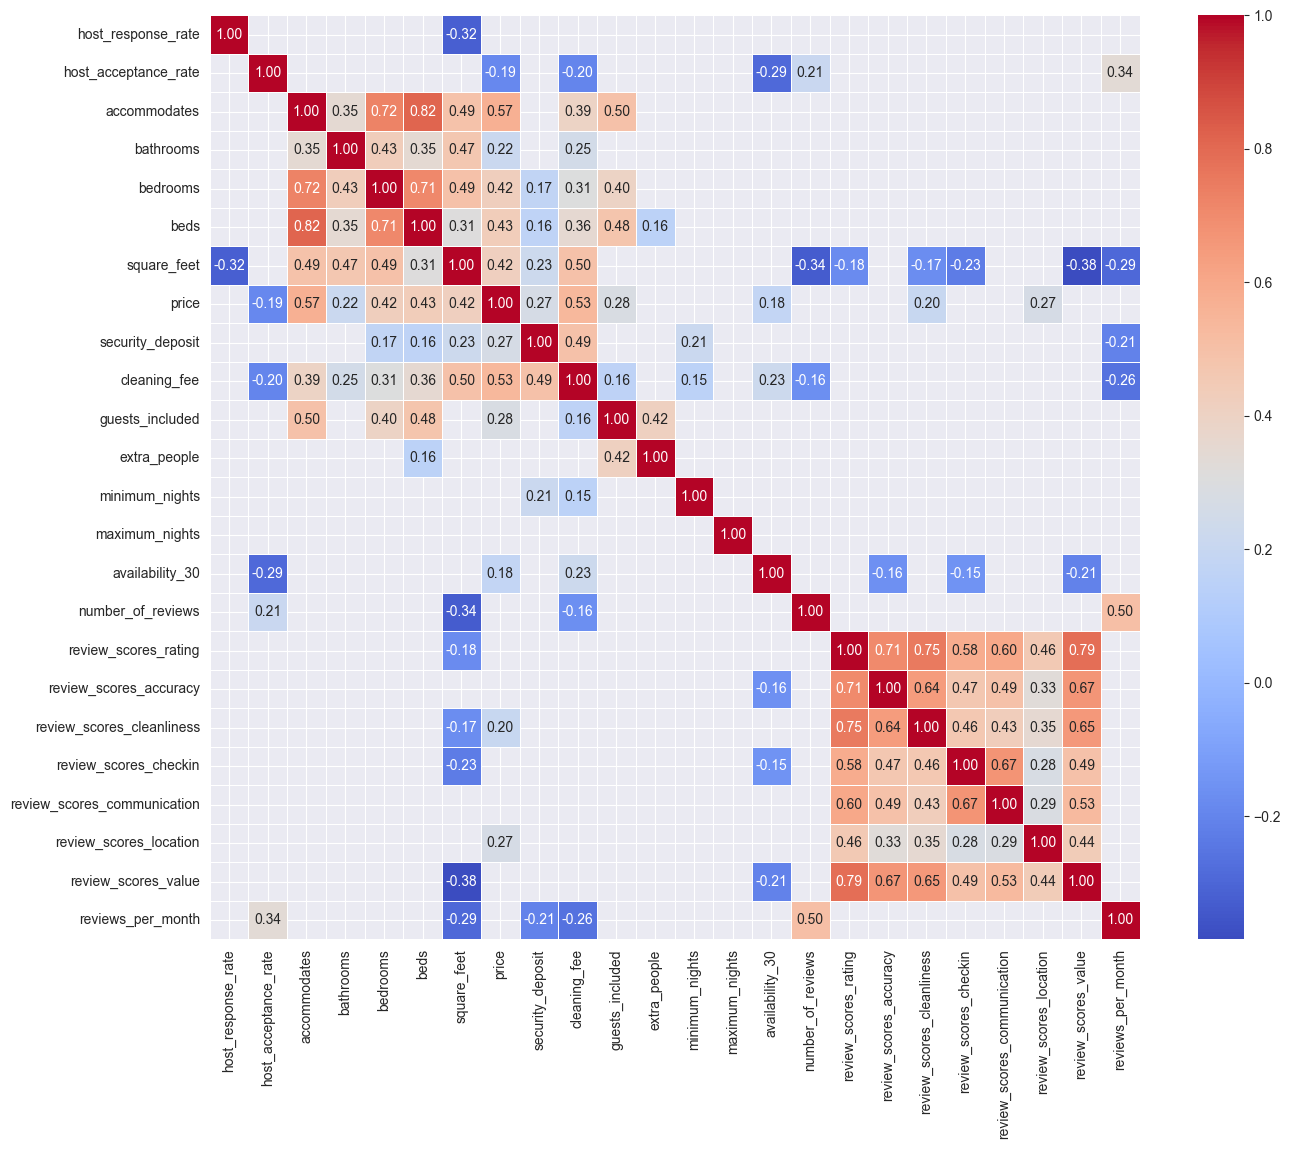

In [171]:
plot_correlation_heatmap(listings_df_fe.drop(columns=(cols_to_remove + date_columns + extra_vars_to_exclude)))

* We can see two blocks of correlations:
    - All the review variables are highly correlated between themselves
    - Construction or accommodation featureas are also correlated
* We can also see that *accommodates* and *beds* are highly correlated, which also makes sense, since all the accommodates will probably have a bed to sleep. Bedrooms is also correlated with these variables for similar reasons.
* Price is slightly positively correlated with cleaning_fee, accommodates, and bedrooms, which can be interpretable as the more accommodates and bedrooms, the higher the price, and from a pricing perspective, because the cleaning fee can be somehow calculated as a percentage of the total price, it can explain its positive correlation. It also has an interesting correlation: negative with reviews_per_month, so it means that the more reviews per month, the cheaper the price (in some cases), but we won't investigate this correlation in this notebook.

Now we'll create a function to evaluate different models. We also created a Feature Engineer pipeline in the file **udacity_courses/project_1/features/feature_engineer.py**, and we'll use it to do all the steps described above

In [209]:
def evaluate_model(df, model, column_to_predict: str, scale: bool=True, log_scale=True):
    # Assume the target column is the last column in the DataFrame
    X = df.drop(columns=[column_to_predict])
    y = df[column_to_predict]
    if log_scale:
        y = np.log(y)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    feature_engineer = FeatureEngineer(cols_to_remove=cols_to_remove, categorical_cols=categorical_cols, cols_to_change_type=cols_to_change_type, date_columns=date_columns, boolean_columns=boolean_columns, cols_to_fill_with_mean=cols_to_fill_with_mean, cols_to_fill_with_imputer=cols_to_fill_with_imputer,
                                   cols_to_fill_with_0=cols_to_fill_with_0, scale=scale)
    X_train = feature_engineer.fit_transform(X_train)
    X_test = feature_engineer.transform(X_test)[X_train.columns]

    coefficient_names = X_train.columns.tolist()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test))

    mae = mean_absolute_error(y_test, y_pred)

    mae_exp = mean_absolute_error(np.exp(y_test), np.exp(y_pred))


    # Print the metrics
    if log_scale:
        print(f"MAPE: (logarithmic scale) {mape:.2f}")
        print(f"MAE (logarithmic scale): {mae: .2f}")
        print(f"MAE (absolute scale): {mae_exp: .2f}")
    else:
        print(f"MAPE: {mape:.2f}")
        print(f"MAE {mae: .2f}")

    return model, coefficient_names

In [178]:
linear_regressor = LinearRegression()
linear_model, variable_names = evaluate_model(listings_df, linear_regressor, "price", scale=True)

Columns ['listing_url', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'street', 'amenities', 'scrape_id', 'last_scraped', 'experiences_offered', 'neighbourhood_group_cleansed', 'state', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names', 'id', 'scrape_id', 'host_id', 'license', 'jurisdiction_names', 'neighbourhood', 'host_verifications', 'smart_location', 'city', 'host_total_listings_count', 'zipcode', 'latitude', 'longitude', 'weekly_price', 'monthly_price']  removed
4 columns with changed to float type
3 date columns removed after get the number of days elapsed until the day 2017-12-31
7 boolean columns changed to bool type
3 categorical columns removed aft

/Users/heribertroig/heribert-roig-personal/udacity_courses/project_1/features/feature_engineer.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[self.encoded_columns] = df.reindex(columns=self.encoded_columns, fill_value=0)[self.encoded_columns]
/Users/heribertroig/heribert-roig-personal/udacity_courses/project_1/features/feature_engineer.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[self.encoded_columns] = df.reindex(columns=self.encoded_columns, fill_value=0)[self.encoded_columns]
/Users/heribertroig/heribert-r

MAPE: 0.05
MAE (logarithmic scale):  0.25
MAE (absolute scale):  47.66


Even though we get a quite high error using this model (an error of about 48$ in the prediction of an accommodation price could be considered unacceptable for any booking platform), we are going to proceed to analyze what are the most important factors that determine a listing price. For that we'll compare the coefficients which are all in the same scale thanks to having normalized them in the Feature Engineer pipeline.

A linear model has these assumptions:
* Linearity
* Independence
* Homoscedasticity
* Normality of Residuals

And we did not verify them, so this could be a cause of the high error:
For linearity, we have many variables that are binary (such as the dummy variables) so they won't be linear.
On independence, variables like bedrooms and beds are probably not independent.
Homoscedasticity and Normality on residuals could fail in binary variales too.

In [179]:
linear_model.intercept_

4.523630740956271

In [198]:
np.exp(linear_model.intercept_)

92.16963527948748

In [199]:
coefficients_df = pd.DataFrame({
    'feature': variable_names,
    'coefficient': linear_model.coef_
})
coefficients_df["abs_value_coef"] = coefficients_df["coefficient"].abs()
coefficients_df = coefficients_df.sort_values(by="abs_value_coef", ascending=False)
coefficients_df

,feature,coefficient,abs_value_coef
114,property_type_Camper/RV,-1.393668e+00,1.393668e+00
146,calendar_updated_30 months ago,1.127681e+00,1.127681e+00
142,calendar_updated_25 months ago,9.621888e-01,9.621888e-01
135,calendar_updated_16 months ago,8.754823e-01,8.754823e-01
44,host_neighbourhood_Central Business District,-8.594757e-01,8.594757e-01
...,...,...,...
150,calendar_updated_5 days ago,-1.661851e-03,1.661851e-03
26,review_scores_communication,-1.458716e-03,1.458716e-03
38,host_neighbourhood_Beacon Hill,-8.313243e-04,8.313243e-04
153,calendar_updated_6 days ago,-6.353523e-05,6.353523e-05


In [203]:
def create_horizontal_barplot(data: pd.Series, x_label='', y_label='', title=''):
    """
    Create a horizontal bar chart for a Pandas Series.

    Parameters:
    - data (pd.Series): Pandas Series containing the data.
    - x_label (str): Label for the x-axis.
    - y_label (str): Label for the y-axis.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 15))
    data.plot(kind='barh', color='skyblue')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

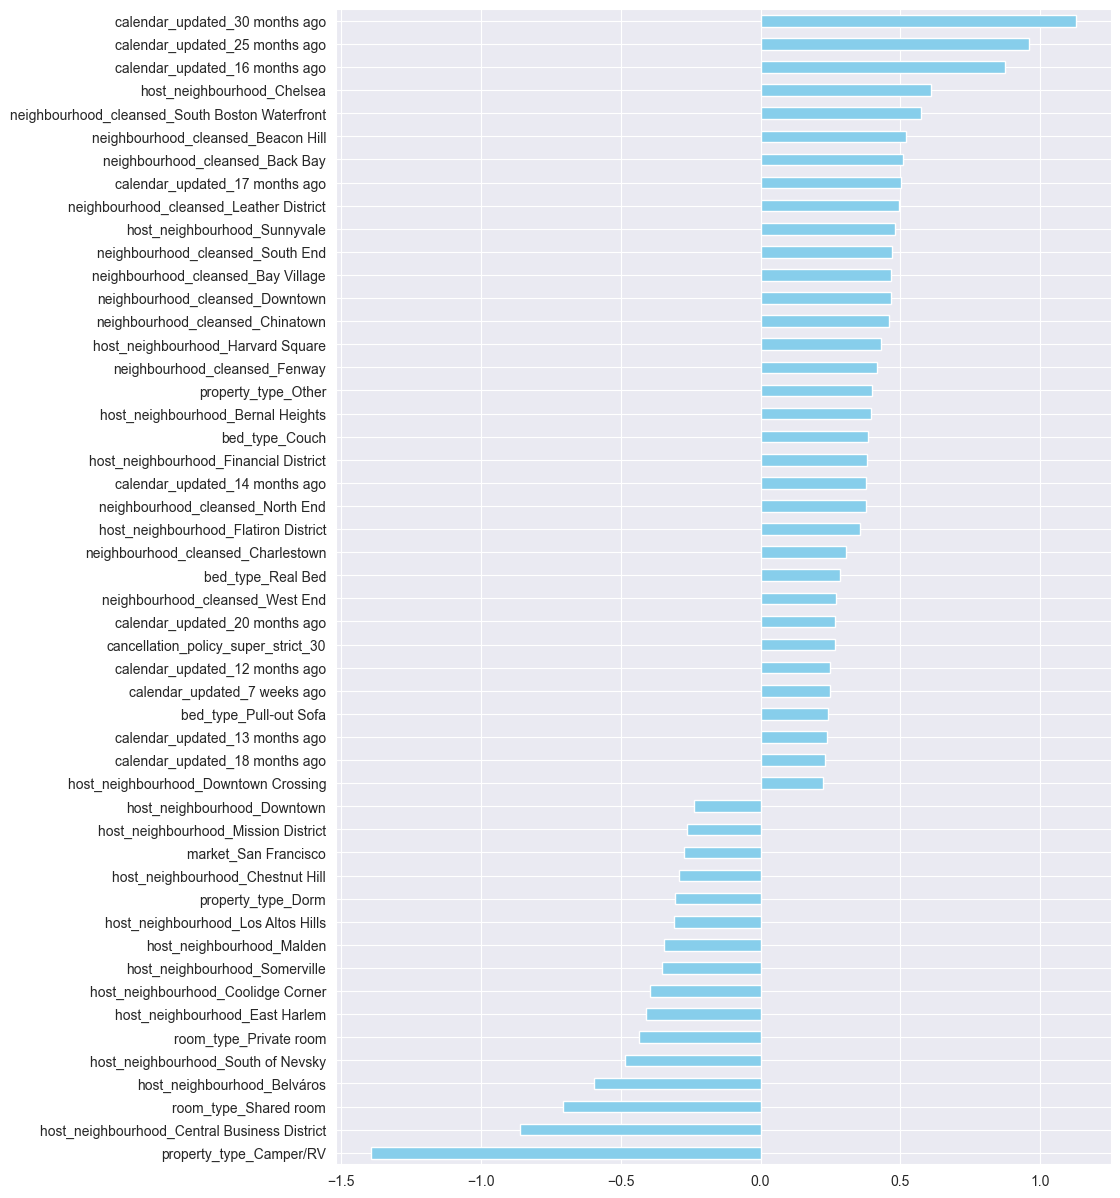

In [204]:
coefficients_df_to_plot = coefficients_df[:50]
create_horizontal_barplot(coefficients_df_to_plot.set_index("feature")["coefficient"].sort_values())

It seems that with the linear model we fitted, the 50 most important features are categorical and dummyfied, which, to be honest, I was not expecting at all

In [210]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model, variable_names = evaluate_model(listings_df, random_forest, "price", scale=True)

Columns ['listing_url', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'street', 'amenities', 'scrape_id', 'last_scraped', 'experiences_offered', 'neighbourhood_group_cleansed', 'state', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names', 'id', 'scrape_id', 'host_id', 'license', 'jurisdiction_names', 'neighbourhood', 'host_verifications', 'smart_location', 'city', 'host_total_listings_count', 'zipcode', 'latitude', 'longitude', 'weekly_price', 'monthly_price']  removed
4 columns with changed to float type
3 date columns removed after get the number of days elapsed until the day 2017-12-31
7 boolean columns changed to bool type
Columns ['listing_url', 'last_scr

ValueError: could not convert string to float: 'within an hour'

The MAE has dropped a bit in comparison with the linear model. However, an error of about 45$ in the price prediction is still too high to be acceptable.

In [200]:
feature_importance_df = pd.DataFrame({
    'feature': variable_names,
    'importance': rf_model.feature_importances_
})
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)
feature_importance_df

,feature,importance
123,room_type_Private room,4.009909e-01
124,room_type_Shared room,5.202888e-02
9,bedrooms,4.389130e-02
8,bathrooms,3.911187e-02
7,accommodates,2.423781e-02
...,...,...
39,host_neighbourhood_Belváros,4.705510e-07
71,host_neighbourhood_Newton,2.537875e-07
110,market_Other (Domestic),1.605447e-07
40,host_neighbourhood_Benton Park,1.279895e-07


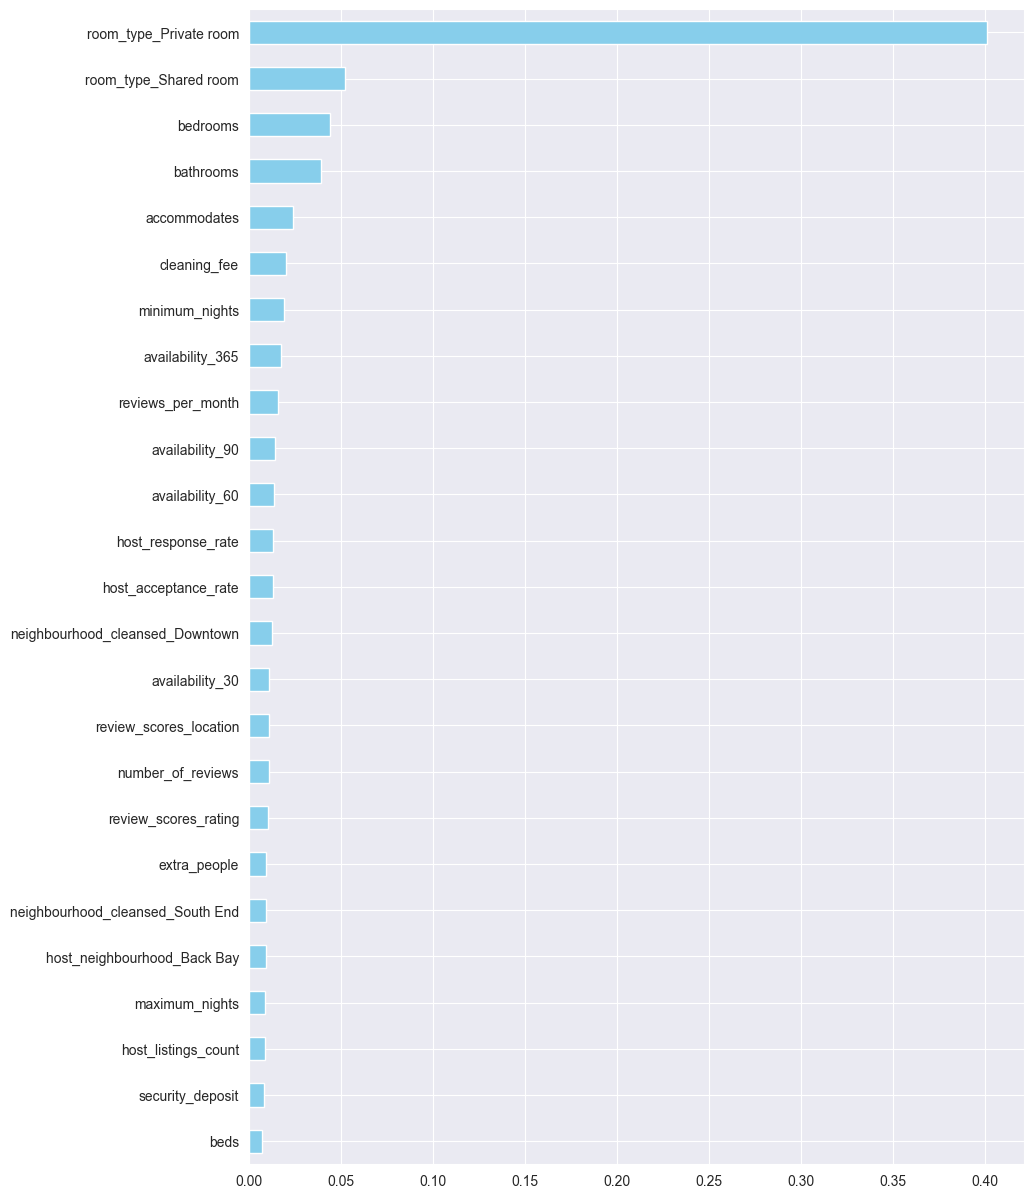

In [206]:
feature_importance_df_to_plot = feature_importance_df[:25]
create_horizontal_barplot(feature_importance_df_to_plot.set_index("feature")["importance"].sort_values())

With the random forest model, it seems that the most important feature is the room type when it is a private room, which makes quite sense